In [1]:
# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the required Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Notes

- There could be multiple applications from the same customer
- Amounts -> Can they be rounded off?

AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE
- Goods Vs Amount loan
- Is lesser amount given than that is asked for? AMT_APPLICATION	AMT_CREDIT	
- Is more amount asked for than that is needed? AMT_APPLICATION	AMT_GOODS_PRICE
- No information on whether the applicant has paid off the previous loans
- AMT_DOWN_PAYMENT & RATE_DOWN_PAYMENT occur together

Current Application & Previous Application
- Do all clients with current application have entries in previous application?
- For each Client, number of previous applications & how many were completed.
- 1 curr_id has multiple prev_ids. Add number of prev_ids associated with this curr_id

Others
- Replace all FLAG_DOCUMENT with a single FLAG_DOCUMENT with the sum
- Correlation matrix
- No information on whether the applicant has paid off the previous loans
- Columns have empty values
- Merge 2 datasets
- How to show/hide output - o

1. Data Cleaning: 
    - Remove the irrelevant columns. 
    - Remove/impute the missing values
2. Outlier handling:
    - Univariate: ordered or unordered, or it may be a numerical variable.
        - Categorical unordered:
        - Categorical ordered
        - Numerical variable: mean, median, mode, quantiles, and box plots, 
            - continuous
            - discrete 
        - Convert numerical variables into categorical ones
    - Multivariate  
        -  Bivariate: 
            - correlation and scatter plots on numerical variables
            - numerical and categorical variables: Boxplot
            - two categorical variables: bar graph
        -  Multivariate: heat maps 
3. Standardising values
Fixing invalid values
Filter data


### Table of Contents <a class="anchor" id="toc"></a>

* [Definitions](#definitions)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)


## Problem Statement

## Definitions <a class="anchor" id="definitions"></a> [TOC](#toc)

In [104]:
def percent(val, total):
    return round(100 * val/total)

def getIQR(df, col):
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    return Q3 - Q1

def getMaxScore(df, col):
    Q3 = df[col].quantile(0.75)
    iqr = getIQR(df, col)
    return Q3 + 1.5 * iqr

def listColumsWithMissingData(df):
    [ print(f"{col:30}  {df[col].isna().sum(): 7d} {100 * df[col].isna().sum()/df.shape[0]: 2.1f}%") for col in df.columns if df[col].isna().any() ]

def getCategoricalValues(df):
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns.sort()
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    for col in cat_columns:
        count_values = df[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df[col].unique().tolist())) if np.NaN not in df[col].unique().tolist() else (df[col].unique().tolist())}")
        
def getNumCategoricalValues(df, ncat_columns):
    ncat_columns.sort()
    print(f"Columns with categorical values {len(ncat_columns)}")
    for col in ncat_columns:
        count_values = df[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 

def makeDFForTarget(df, col, taretVal):
    df_ = df[df['TARGET']==taretVal][[col,'TARGET']]
    cnt = df_.shape[0]
    df_ = groupByAndCount(df_, col, skipPercent=False)
    df_.rename(columns={'Count':f'Target={taretVal}'},inplace=True)
    #print(df_)
    return df_, cnt


def makeDFForTargets(df, col):
    df_1, cnt_1 = makeDFForTarget(df, col, 1)
    df_0, cnt_0 = makeDFForTarget(df, col, 0)
    print(cnt_1, cnt_0)

    df_ = df_0.merge(df_1, how='left',on=col)
    print(df_)
    df_.set_index(col, inplace=True)
    return df_


def groupByAndCount(df, col, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by=col).agg({col:"count"})
    df_.rename(columns={col:'Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by='Count', ascending=False, inplace=True)
    if not skipPercent:
        df_['%'] = round((df_['Count']/total_rows)*100,2)
    return df_
    
def groupPerTarget(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]; print(df_1.shape[0])
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]; print(df_0.shape[0])
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    print(df_)
    
    return df_

# -----
def groupByTargetAndCount(df, value, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by='TARGET').agg({'TARGET':"count"})
    df_.rename(columns={'TARGET': f'{value}_Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by=f'{value}_Count', ascending=False, inplace=True)
    if not skipPercent:
        df_[f'{value}_%'] = round((df_[f'{value}_Count']/total_rows)*100,2)
    return df_

def makeDFForTarget1(df, col, value):
    df_ = df[df[col]==value][[col,'TARGET']]
    #print(df_)
    cnt = df_.shape[0]
    df_ = groupByTargetAndCount(df_, value, skipPercent=False)
    return df_, cnt


def makeDFForTargets1(df, col):
    df_1, cnt_1 = makeDFForTarget1(df_ca, col, 'N')
    df_0, cnt_0 = makeDFForTarget1(df_ca, col, 'Y')
    print(cnt_1, cnt_0)
    df_ = df_0.merge(df_1, how='left',on='TARGET')
    print(df_)
    df_.set_index('TARGET', inplace=True)
    df_ = df_.transpose()
    df_ = df_.loc[['Y_%', 'N_%']]
    return df_
# ---

In [92]:
def plotBar(df, title, w=10, h=10, logy=False):
    plt.figure(figsize=(w, h), dpi=80)
    ax = df.plot.bar(logy=logy) 
    # Annotate
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)
    plt.show()

def annotate(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

def plotScatter(df, col1, col2, title, pos=1, log=False):
    plt.subplot(1, 2, pos)
    ax = df.plot.scatter(col1, col2,figsize=(10, 6))
    if log == True: ax.set_xscale('log')
    ax.set_title(title)
    plt.show()

# TODO: annotation - add %
def compare(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTarget(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Target=0','Target=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Target=0%','Target=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - %age values")

## Data Exploration - Previous Application

### Data Reading & Data Types 

In [5]:
#Read the data in pandas
df_pa = pd.read_csv("data/previous_application.csv")

In [6]:
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [7]:
PA_COLUMNS = df_pa.columns.tolist()
PA_ID_COLUMNS = ['SK_ID_PREV','SK_ID_CURR']
PA_NCAT_COLUMNS = ['NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'SELLERPLACE_AREA', 'HOUR_APPR_PROCESS_START']
print(len(max(PA_COLUMNS)))
getNumCategoricalValues(df_pa, PA_NCAT_COLUMNS)

26
Columns with categorical values 4
HOUR_APPR_PROCESS_START    : [  24] --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
NFLAG_INSURED_ON_APPROVAL  : [   3] --> [0.0, 1.0, nan]
NFLAG_LAST_APPL_IN_DAY     : [   2] --> [0, 1]
SELLERPLACE_AREA           : [2097] --> [-1, 6, 20, 35, 50, 61, 83, 130, 136, 200]...[887, 1164, 1419, 1948, 2054, 2164, 2233, 2420, 3420, 6989]


In [8]:
getCategoricalValues(df_pa)

Columns with categorical values 16 --> ['CHANNEL_TYPE', 'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'WEEKDAY_APPR_PROCESS_START']
CHANNEL_TYPE                : [ 8] --> ['AP+ (Cash loan)', 'Car dealer', 'Channel of corporate sales', 'Contact center', 'Country-wide', 'Credit and cash offices', 'Regional / Local', 'Stone']
CODE_REJECT_REASON          : [ 9] --> ['CLIENT', 'HC', 'LIMIT', 'SCO', 'SCOFR', 'SYSTEM', 'VERIF', 'XAP', 'XNA']
FLAG_LAST_APPL_PER_CONTRACT : [ 2] --> ['N', 'Y']
NAME_CASH_LOAN_PURPOSE      : [25] --> ['Building a house or an annex', 'Business development', 'Buying a garage', 'Buying a holiday home / land', 'Buying a home', 'Buying a new car', 'Buying a used car', 'Car repairs', 'Education', 'Everyday 

In [9]:
df_pa[df_pa.columns.difference(PA_ID_COLUMNS + PA_NCAT_COLUMNS)].describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,CNT_PAYMENT,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
count,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.297984e+06,1.670214e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,774370.000000,5951.000000,5951.000000
mean,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.605408e+01,-8.806797e+02,342209.855039,13826.269337,76582.403064,33767.774054,81992.343838,0.079637,0.188357,0.773503
std,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,1.456729e+01,7.790997e+02,88916.115833,72444.869708,149647.415123,106857.034789,153303.516729,0.107823,0.087671,0.100879
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,-2.922000e+03,-2922.000000,-2892.000000,-2889.000000,-2801.000000,-2874.000000,-0.000015,0.034781,0.373150
25%,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,6.000000e+00,-1.300000e+03,365243.000000,-1628.000000,-1314.000000,-1242.000000,-1270.000000,0.000000,0.160716,0.715645
50%,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,-5.810000e+02,365243.000000,-831.000000,-537.000000,-361.000000,-499.000000,0.051605,0.189122,0.835095
75%,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,2.400000e+01,-2.800000e+02,365243.000000,-411.000000,-74.000000,129.000000,-44.000000,0.108909,0.193330,0.852537
max,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,8.400000e+01,-1.000000e+00,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000,1.000000,1.000000


In [10]:
df_pa.loc[df_pa['NAME_PRODUCT_TYPE']!='x-sell'][['NAME_PRODUCT_TYPE','NAME_SELLER_INDUSTRY']]

,NAME_PRODUCT_TYPE,NAME_SELLER_INDUSTRY
0,XNA,Connectivity
4,walk-in,XNA
6,XNA,XNA
7,XNA,XNA
8,XNA,XNA
...,...,...
1670206,walk-in,XNA
1670207,walk-in,XNA
1670209,XNA,Furniture
1670210,XNA,Furniture


In [11]:
df_pa[['NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE','RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']]

,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,POS,XNA,0.000000,0.182832,0.867336,middle,POS mobile with interest
1,Cash,x-sell,NaN,NaN,NaN,low_action,Cash X-Sell: low
2,Cash,x-sell,NaN,NaN,NaN,high,Cash X-Sell: high
3,Cash,x-sell,NaN,NaN,NaN,middle,Cash X-Sell: middle
4,Cash,walk-in,NaN,NaN,NaN,high,Cash Street: high
...,...,...,...,...,...,...,...
1670209,POS,XNA,0.000000,NaN,NaN,low_normal,POS industry with interest
1670210,POS,XNA,0.340554,NaN,NaN,middle,POS industry with interest
1670211,POS,XNA,0.101401,NaN,NaN,low_normal,POS household with interest
1670212,Cash,x-sell,NaN,NaN,NaN,low_normal,Cash X-Sell: low


Check if there are multiple entries for each client in the previous application.

In [12]:
groupByAndCount(df_pa, 'SK_ID_PREV')

,SK_ID_PREV,Count
0,1000001,1
1113473,2230564,1
1113483,2230574,1
1113482,2230573,1
1113481,2230572,1
...,...,...
556734,1615728,1
556733,1615727,1
556732,1615726,1
556731,1615725,1


In [13]:
groupByAndCount(df_pa, 'SK_ID_CURR')


,SK_ID_CURR,Count
83581,187868,77
157523,265681,73
70132,173680,72
135448,242412,68
101569,206783,67
...,...,...
200467,310872,1
85950,190357,1
85951,190358,1
33175,134814,1


There is only one entry per client

Do all clients in current application have an entry in the previous application?

In [14]:
groupByAndCount(df_pa, 'NAME_CONTRACT_STATUS', skipPercent=False)

,NAME_CONTRACT_STATUS,Count,%
0,Approved,1036781,62.07
1,Canceled,316319,18.94
2,Refused,290678,17.40
3,Unused offer,26436,1.58


In [15]:
groupByAndCount(df_pa, 'NAME_CONTRACT_TYPE', skipPercent=False)

,NAME_CONTRACT_TYPE,Count,%
0,Cash loans,747553,44.76
1,Consumer loans,729151,43.66
2,Revolving loans,193164,11.57
3,XNA,346,0.02


In [16]:
groupByAndCount(df_pa, 'NAME_CLIENT_TYPE', skipPercent=False)

,NAME_CLIENT_TYPE,Count,%
2,Repeater,1231261,73.72
0,New,301363,18.04
1,Refreshed,135649,8.12
3,XNA,1941,0.12


In [17]:
df_pa['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [18]:
groupByAndCount(df_pa, 'NAME_PORTFOLIO', skipPercent=False)

,NAME_PORTFOLIO,Count,%
3,POS,691011,41.37
2,Cash,461563,27.63
4,XNA,372230,22.29
0,Cards,144985,8.68
1,Cars,425,0.03


In [19]:
groupByAndCount(df_pa, 'NAME_GOODS_CATEGORY', skipPercent=False)

,NAME_GOODS_CATEGORY,Count,%
27,XNA,950809,56.93
19,Mobile,224708,13.45
7,Consumer Electronics,121576,7.28
5,Computers,105769,6.33
2,Audio/Video,99441,5.95
11,Furniture,53656,3.21
22,Photo / Cinema Equipment,25021,1.50
6,Construction Materials,24995,1.50
4,Clothing and Accessories,23554,1.41
3,Auto Accessories,7381,0.44


In [20]:
groupByAndCount(df_pa, 'NAME_PRODUCT_TYPE', skipPercent=False)

,NAME_PRODUCT_TYPE,Count,%
0,XNA,1063666,63.68
2,x-sell,456287,27.32
1,walk-in,150261,9.00


In [21]:
groupByAndCount(df_pa, 'CHANNEL_TYPE', skipPercent=False)

,CHANNEL_TYPE,Count,%
5,Credit and cash offices,719968,43.11
4,Country-wide,494690,29.62
7,Stone,212083,12.70
6,Regional / Local,108528,6.50
3,Contact center,71297,4.27
0,AP+ (Cash loan),57046,3.42
2,Channel of corporate sales,6150,0.37
1,Car dealer,452,0.03


In [22]:
groupByAndCount(df_pa, 'PRODUCT_COMBINATION', skipPercent=False)

,PRODUCT_COMBINATION,Count,%
2,Cash,285990,17.12
9,POS household with interest,263622,15.78
13,POS mobile with interest,220670,13.21
8,Cash X-Sell: middle,143883,8.61
7,Cash X-Sell: low,130248,7.80
0,Card Street,112582,6.74
11,POS industry with interest,98833,5.92
10,POS household without interest,82908,4.96
1,Card X-Sell,80582,4.82
3,Cash Street: high,59639,3.57


In [23]:
df_pa['RATE_DOWN_PAYMENT'].isna().sum() 

895844

In [24]:
df_pa['interest'] = np.NaN
df_pa['interest'].isna().sum() 

1670214

In [25]:
df_pa['interest'] = df_pa.apply(lambda x: x['RATE_DOWN_PAYMENT'] + x['RATE_INTEREST_PRIMARY'] + x['RATE_INTEREST_PRIVILEGED'], axis=1)

In [26]:
df_pa['interest'] 

0          1.050168
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1670209         NaN
1670210         NaN
1670211         NaN
1670212         NaN
1670213         NaN
Name: interest, Length: 1670214, dtype: float64

In [27]:

PRODUCT_COMBINATION_COLUMNS = ['interest', 'NAME_PORTFOLIO', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE',   'NAME_YIELD_GROUP', 	'PRODUCT_COMBINATION']

In [28]:
df_pa[PRODUCT_COMBINATION_COLUMNS]

,interest,NAME_PORTFOLIO,NAME_GOODS_CATEGORY,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,1.050168,POS,Mobile,XNA,middle,POS mobile with interest
1,NaN,Cash,XNA,x-sell,low_action,Cash X-Sell: low
2,NaN,Cash,XNA,x-sell,high,Cash X-Sell: high
3,NaN,Cash,XNA,x-sell,middle,Cash X-Sell: middle
4,NaN,Cash,XNA,walk-in,high,Cash Street: high
...,...,...,...,...,...,...
1670209,NaN,POS,Furniture,XNA,low_normal,POS industry with interest
1670210,NaN,POS,Furniture,XNA,middle,POS industry with interest
1670211,NaN,POS,Consumer Electronics,XNA,low_normal,POS household with interest
1670212,NaN,Cash,XNA,x-sell,low_normal,Cash X-Sell: low


In [29]:
# TODO: Change this to .csv
df_columns = pd.read_excel("data/columns_description.xlsx")
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   160 non-null    int64  
 1   Table        160 non-null    object 
 2   Category     154 non-null    object 
 3   Values       45 non-null     object 
 4   Common       8 non-null      float64
 5   Type         160 non-null    object 
 6   Remarks      20 non-null     object 
 7   Row          160 non-null    object 
 8   Description  160 non-null    object 
 9   Special      69 non-null     object 
 10  Unnamed: 10  3 non-null      object 
dtypes: float64(1), int64(1), object(9)
memory usage: 13.9+ KB


In [30]:
PA_CONTRACT_COLUMNS = df_columns[(df_columns['Table']=='previous_application.csv') & (df_columns['Category']=='CONTRACT')]['Row'].tolist()
PA_CONTRACT_COLUMNS

['NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE']

In [31]:
df_pa_contract = df_pa[['SK_ID_PREV']  + PA_CONTRACT_COLUMNS]

In [32]:
df_pa_contract['AMT_APP_CRED_DIFF'] = df_pa_contract['AMT_APPLICATION'] - df_pa_contract['AMT_CREDIT']
df_pa_contract['AMT_APP_GOOD_DIFF'] = df_pa['AMT_APPLICATION'] - df_pa['AMT_GOODS_PRICE']

In [33]:
df_pa_contract['AMT_APP_CRED_DIFF'] 

0              0.0
1         -72171.0
2         -23944.5
3         -20790.0
4         -66555.0
            ...   
1670209   -44104.5
1670210    23458.5
1670211     2713.5
1670212   -11880.0
1670213        0.0
Name: AMT_APP_CRED_DIFF, Length: 1670214, dtype: float64

In [34]:
# Is the application amount > the goods price? Is the credit amount < application amount? 
df_pa_contract_ = df_pa_contract[(df_pa_contract['AMT_APP_GOOD_DIFF'] > 0) | (df_pa_contract['AMT_APP_CRED_DIFF'] > 0)] [['SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'AMT_APP_CRED_DIFF', 'AMT_APP_GOOD_DIFF']]

In [35]:
df_pa_contract_.to_csv("out/temp.csv")

In [36]:
# Looks like AMT_DOWN_PAYMENT & RATE_DOWN_PAYMENT occur together. Check if there is AMT_DOWN_PAYMENT if there is no RATE_DOWN_PAYMENT? 
df_pa[ ((df_pa['RATE_DOWN_PAYMENT'] == 0) | (df_pa['RATE_DOWN_PAYMENT'].isna() == True)) & (df_pa['AMT_DOWN_PAYMENT'] > 0) ][['SK_ID_PREV', 'RATE_DOWN_PAYMENT', 'AMT_DOWN_PAYMENT']] #

,SK_ID_PREV,RATE_DOWN_PAYMENT,AMT_DOWN_PAYMENT


In [37]:
df_pa.loc[df_pa['NAME_CONTRACT_STATUS'] == 'Refused'].to_csv("out/refused.csv")

In [38]:
df_pa_curr_ids = groupByAndCount(df_pa, 'SK_ID_CURR')

In [39]:
df_pa_curr_ids

,SK_ID_CURR,Count
83581,187868,77
157523,265681,73
70132,173680,72
135448,242412,68
101569,206783,67
...,...,...
200467,310872,1
85950,190357,1
85951,190358,1
33175,134814,1


In [40]:
df_pa_curr_ids[df_pa_curr_ids['Count'] == 1].shape[0]

60458

In [41]:
df_pa_curr_ids[df_pa_curr_ids['Count'] > 1].to_csv("out/multiple_curr_id.csv")

In [42]:
curr_ids_multiple_prev_app = df_pa_curr_ids[df_pa_curr_ids['Count'] > 1]['SK_ID_CURR'].tolist()

In [43]:
curr_ids_multiple_prev_app[0:4]

[187868, 265681, 173680, 242412]

## Data Exploration - Current Application

In [114]:
df_ca_orig = pd.read_csv("data/application_data.csv")

### Data Cleaning - Remove invalid data
 - EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3: Meaning of the columns/variables is not known

In [115]:
print(f"Shape - before cleanup {df_ca_orig.shape}")
df_ca_orig.drop(columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)
print(f"Shape - after cleanup {df_ca_orig.shape}")

Shape - before cleanup (307511, 122)
Shape - after cleanup (307511, 119)


In [116]:
df_ca_orig['TARGET'].isna().sum()

0

In [118]:
df_ca = df_ca_orig.copy(deep=True)
print(df_ca.shape)

(307511, 119)


### 1. Demographic
- PERSONAL - Gender, Education Type, Family Status, Housing Type, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY
- PROFESSIONAL - Occupation Type, ORGANIZATION_TYPE, NAME_INCOME_TYPE

24825
282686
                Total  Target=1  Target=0  Target=1%  Target=0%
CODE_GENDER                                                    
F            202448.0   14170.0    188278        7.0       93.0
M            105059.0   10655.0     94404       10.0       90.0
XNA               NaN       NaN         4        NaN        NaN


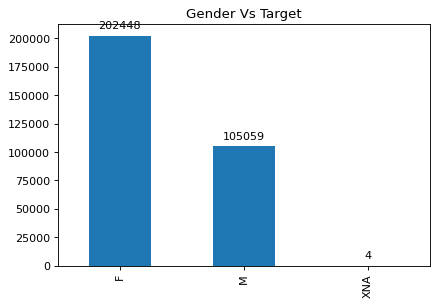

In [49]:
df_ca_gender = groupPerTarget(df_ca, 'CODE_GENDER')
plotBar(df_ca['CODE_GENDER'].value_counts(), "Gender Vs Target", w=6, h=4)

24825
282686
                Total  Target=1  Target=0  Target=1%  Target=0%
CODE_GENDER                                                    
F            202448.0   14170.0    188278        7.0       93.0
M            105059.0   10655.0     94404       10.0       90.0
XNA               NaN       NaN         4        NaN        NaN
24825
282686
                                Total  Target=1  Target=0  Target=1%  \
NAME_EDUCATION_TYPE                                                    
Academic degree                   164         3       161        2.0   
Higher education                74863      4009     70854        5.0   
Incomplete higher               10277       872      9405        8.0   
Lower secondary                  3816       417      3399       11.0   
Secondary / secondary special  218391     19524    198867        9.0   

                               Target=0%  
NAME_EDUCATION_TYPE                       
Academic degree                     98.0  
Higher education    

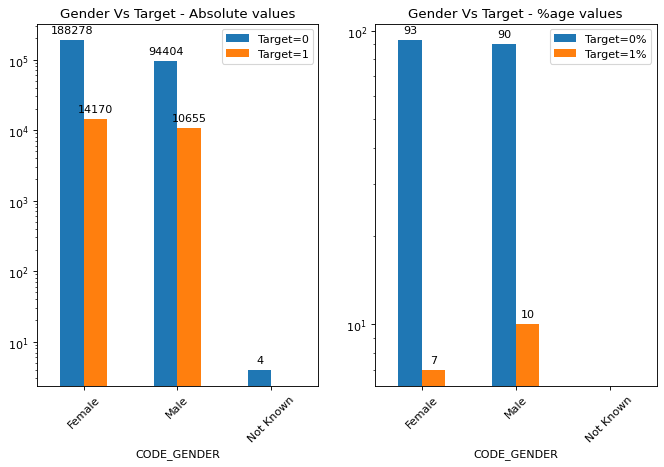

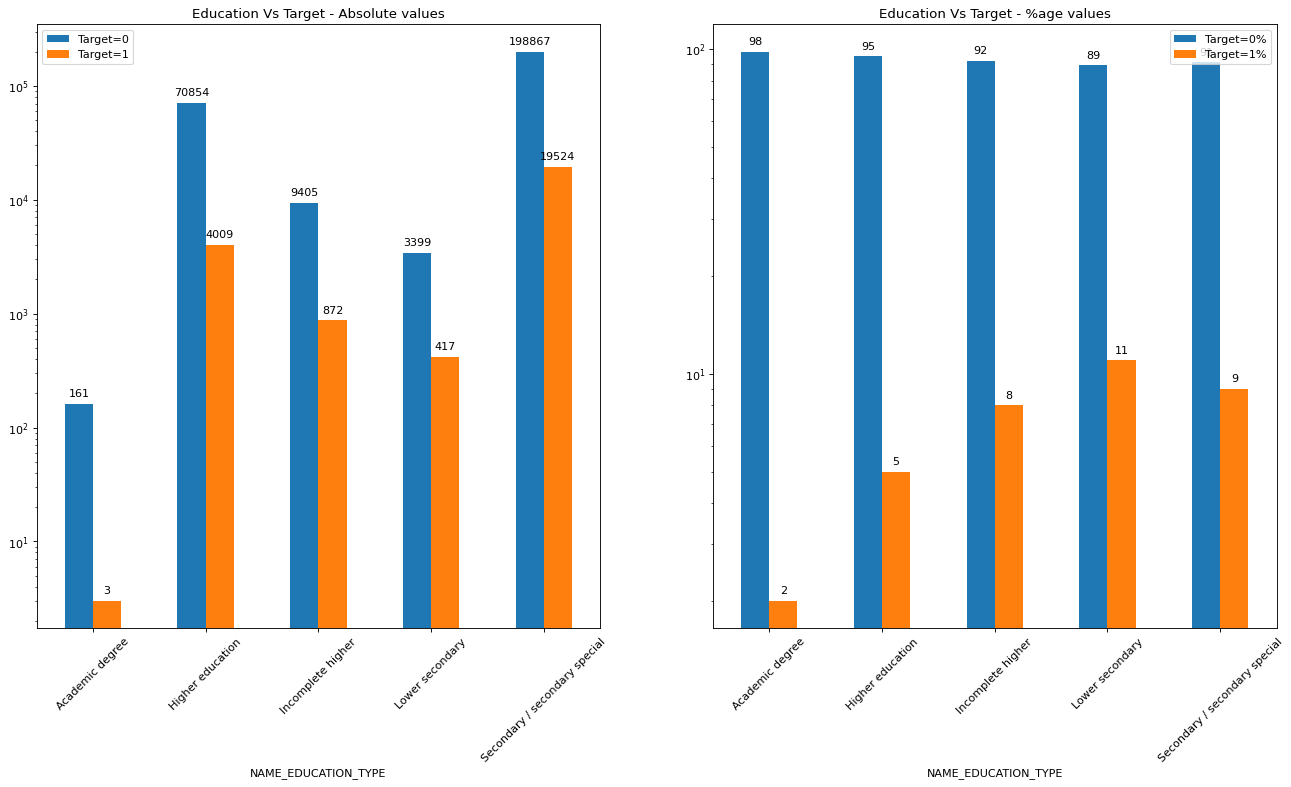

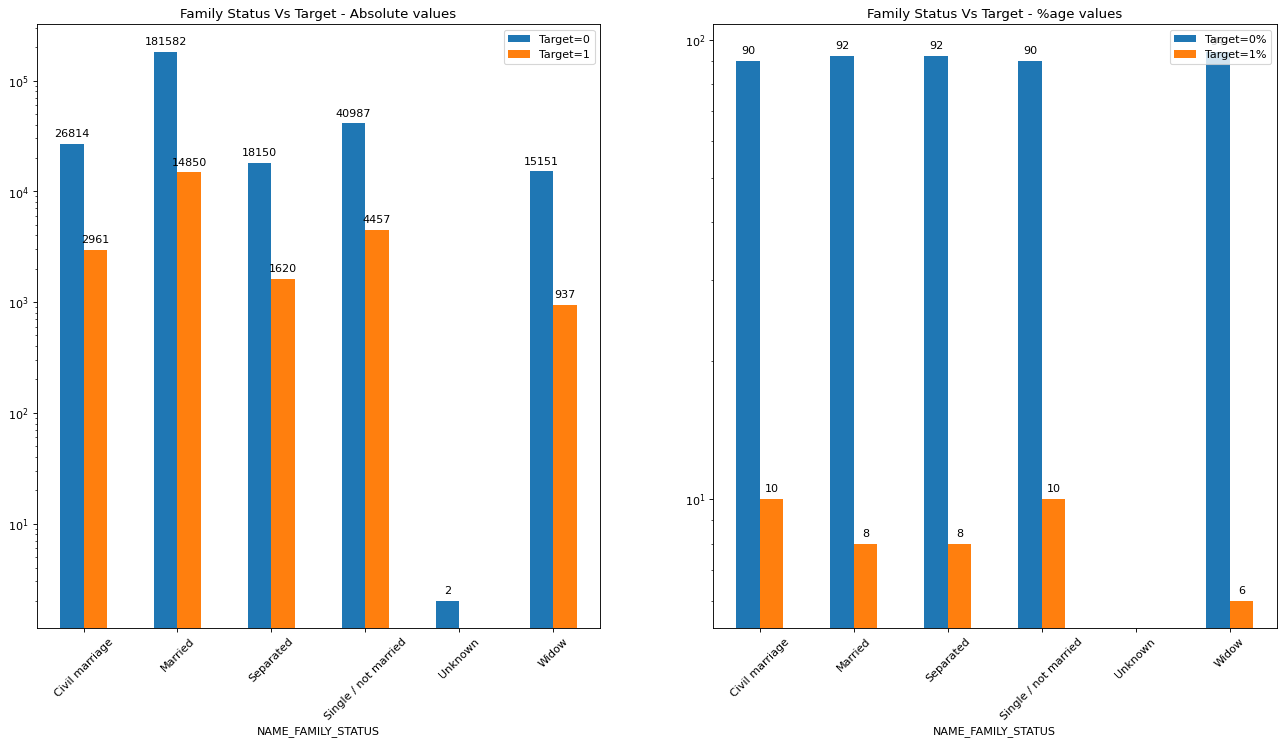

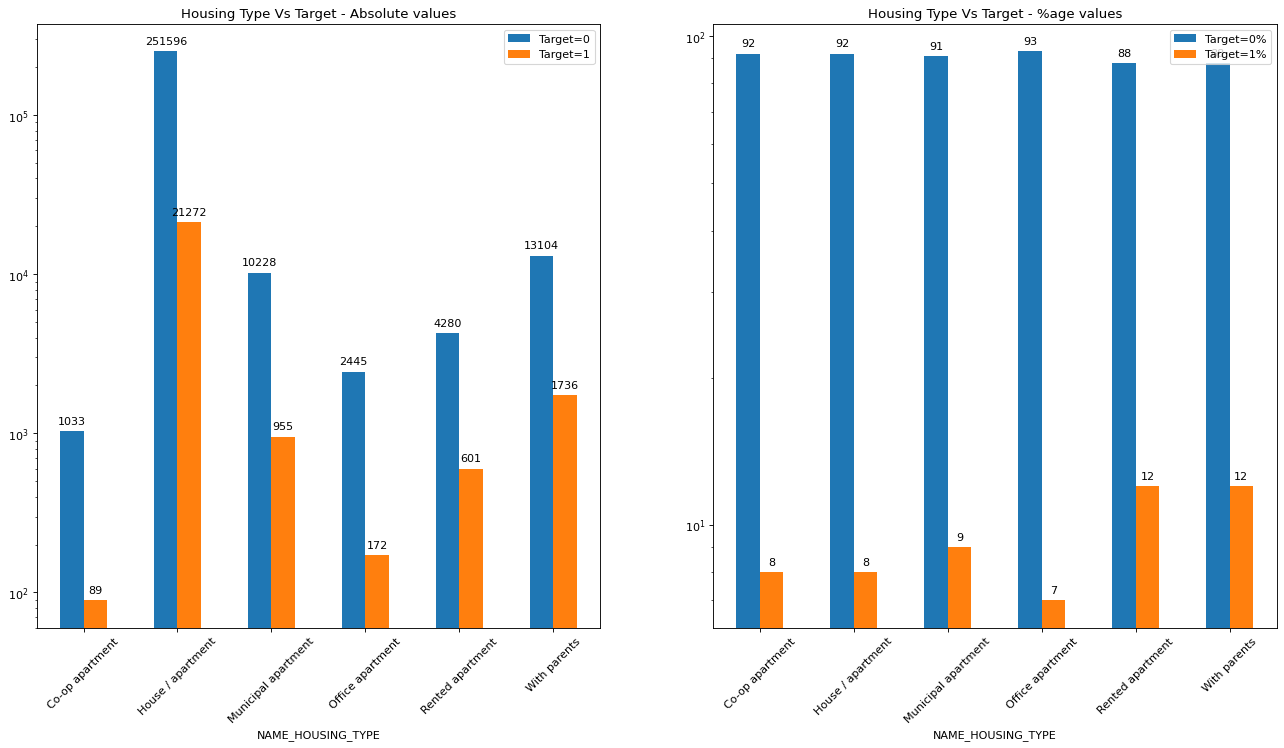

In [90]:
compare(df_ca, 'CODE_GENDER', 'Gender', labels=['Female', 'Male', 'Not Known'])
compare(df_ca, 'NAME_EDUCATION_TYPE', 'Education Type',labels=['Academic degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special'], figsize=(20, 10))
compare(df_ca, 'NAME_FAMILY_STATUS', 'Family Status',labels=['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Unknown', 'Widow'], figsize=(20, 10))
compare(df_ca, 'NAME_HOUSING_TYPE', 'Housing Type',labels=['Co-op apartment', 'House / apartment', 'Municipal apartment', 'Office apartment', 'Rented apartment', 'With parents'], figsize=(20, 10))

ORGANIZATION_TYPE - Missing values: 0
24825
282686
                        Total  Target=1  Target=0  Target=1%  Target=0%
ORGANIZATION_TYPE                                                      
Advertising               429        35       394        8.0       92.0
Agriculture              2454       257      2197       10.0       90.0
Bank                     2507       130      2377        5.0       95.0
Business Entity Type 1   5984       487      5497        8.0       92.0
Business Entity Type 2  10553       900      9653        9.0       91.0
Business Entity Type 3  67992      6323     61669        9.0       91.0
Cleaning                  260        29       231       11.0       89.0
Construction             6721       785      5936       12.0       88.0
Culture                   379        21       358        6.0       94.0
Electricity               950        63       887        7.0       93.0
Emergency                 560        40       520        7.0       93.0
Government   

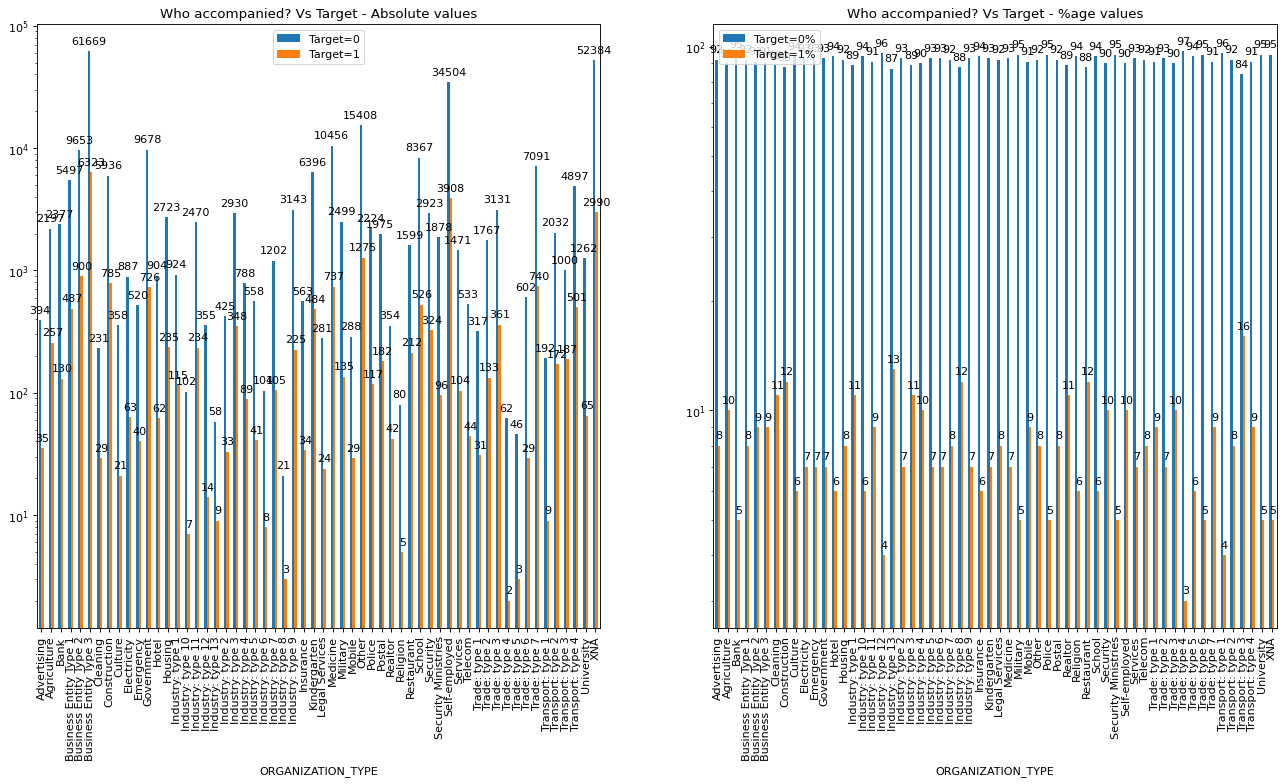

In [93]:
print("ORGANIZATION_TYPE - Missing values:", df_ca['ORGANIZATION_TYPE'].isna().sum())
compare(df_ca,'ORGANIZATION_TYPE', "ORGANIZATION_TYPE",figsize=(20, 10))

NAME_INCOME_TYPE - Missing values: 0
24825
282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
NAME_INCOME_TYPE                                                        
Businessman                NaN       NaN        10        NaN        NaN
Commercial associate   71617.0    5360.0     66257        7.0       93.0
Maternity leave            5.0       2.0         3       40.0       60.0
Pensioner              55362.0    2982.0     52380        5.0       95.0
State servant          21703.0    1249.0     20454        6.0       94.0
Student                    NaN       NaN        18        NaN        NaN
Unemployed                22.0       8.0        14       36.0       64.0
Working               158774.0   15224.0    143550       10.0       90.0
NAME_TYPE_SUITE - Missing values: 1292
24825
282686
                  Total  Target=1  Target=0  Target=1%  Target=0%
NAME_TYPE_SUITE                                                  
Children           3267       241   

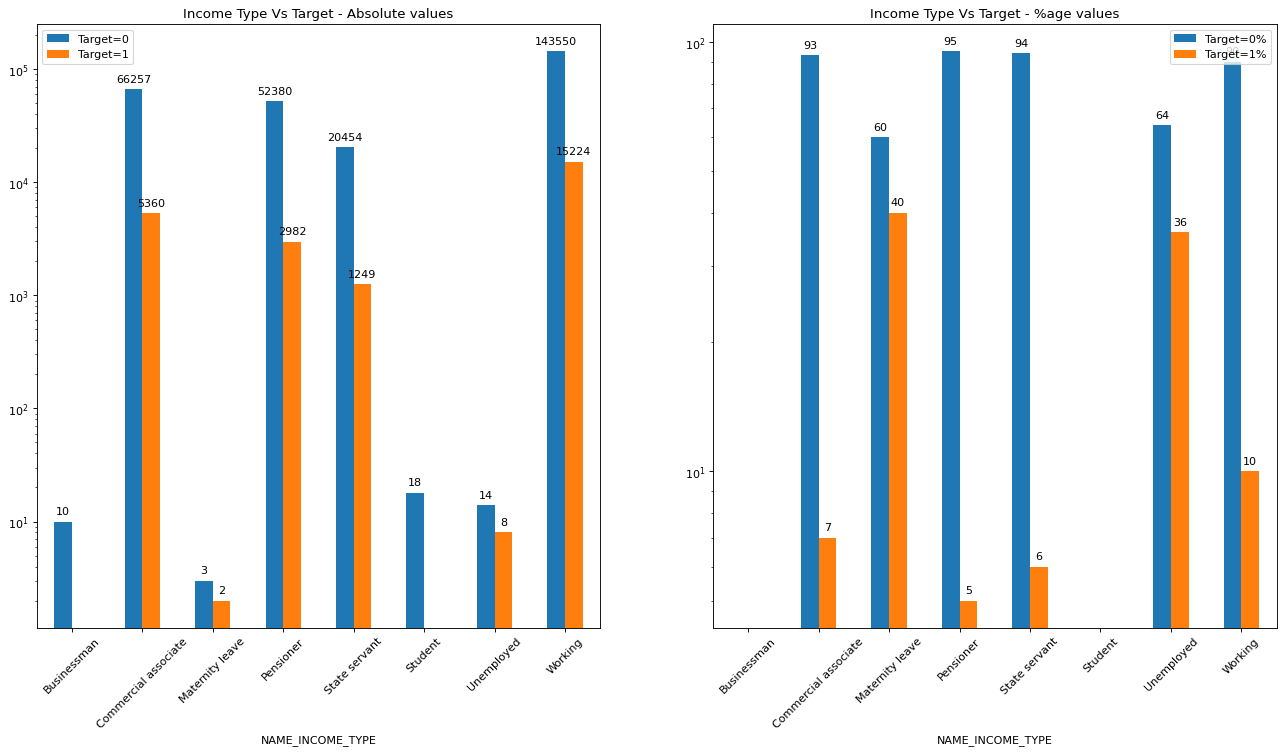

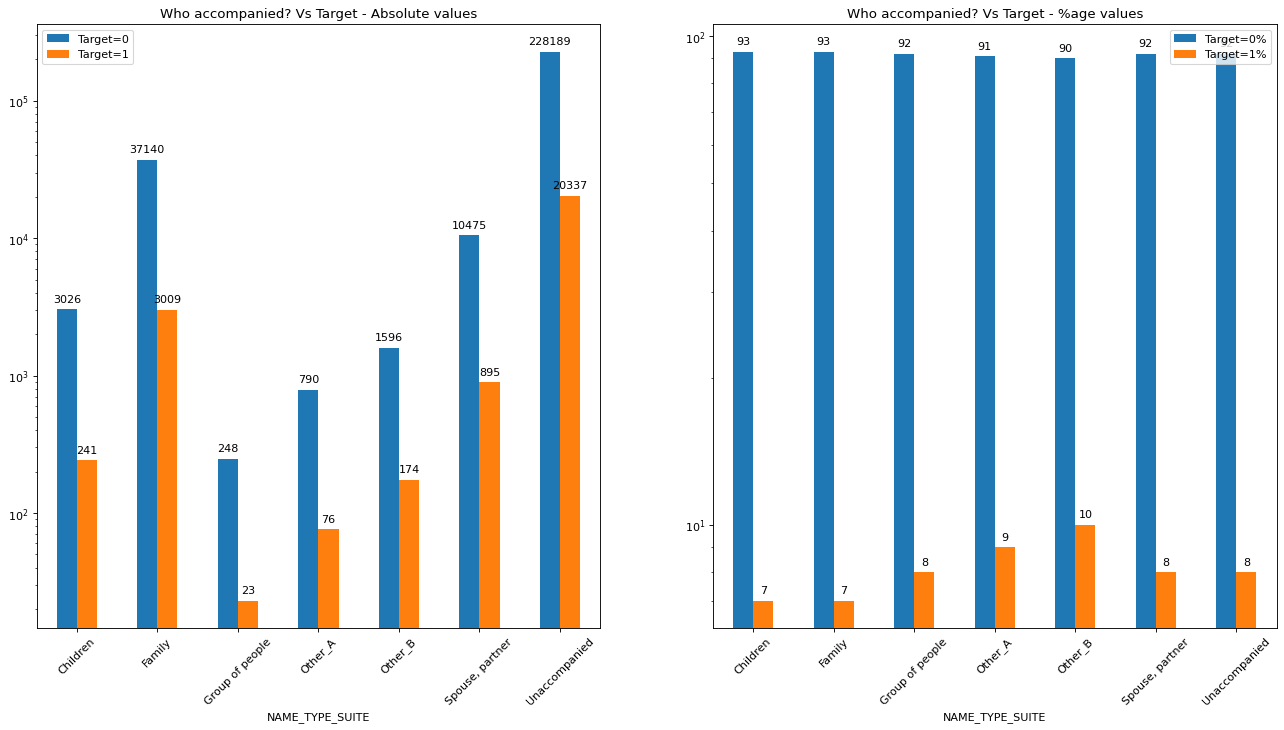

In [80]:
# TODO: Repalce NaN with 0
print("NAME_INCOME_TYPE - Missing values:", df_ca['NAME_INCOME_TYPE'].isna().sum())
compare(df_ca,'NAME_INCOME_TYPE',['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant',  
            'Student', 'Unemployed','Working'], 'Income Type',figsize=(20, 10))


print("NAME_INCOME_TYPE - Missing values:", df_ca['NAME_INCOME_TYPE'].isna().sum())
compare(df_ca,'NAME_INCOME_TYPE',['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant',  
            'Student', 'Unemployed','Working'], 'Income Type',figsize=(20, 10))

,CNT_CHILDREN,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,AGE
count,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,104582.000000,307509.000000,307510.000000,307511.000000
mean,0.417052,1.687979e+05,0.020868,-16036.995067,63815.045904,12.061091,2.152665,-962.858788,43.936973
std,0.722121,2.371231e+05,0.013831,4363.988632,141275.766519,11.944812,0.910682,826.808487,11.956133
min,0.000000,2.565000e+04,0.000290,-25229.000000,-17912.000000,0.000000,1.000000,-4292.000000,20.517808
25%,0.000000,1.125000e+05,0.010006,-19682.000000,-2760.000000,5.000000,2.000000,-1570.000000,34.008219
50%,0.000000,1.471500e+05,0.018850,-15750.000000,-1213.000000,9.000000,2.000000,-757.000000,43.150685
75%,1.000000,2.025000e+05,0.028663,-12413.000000,-289.000000,15.000000,3.000000,-274.000000,53.923288
max,19.000000,1.170000e+08,0.072508,-7489.000000,365243.000000,91.000000,20.000000,0.000000,69.120548


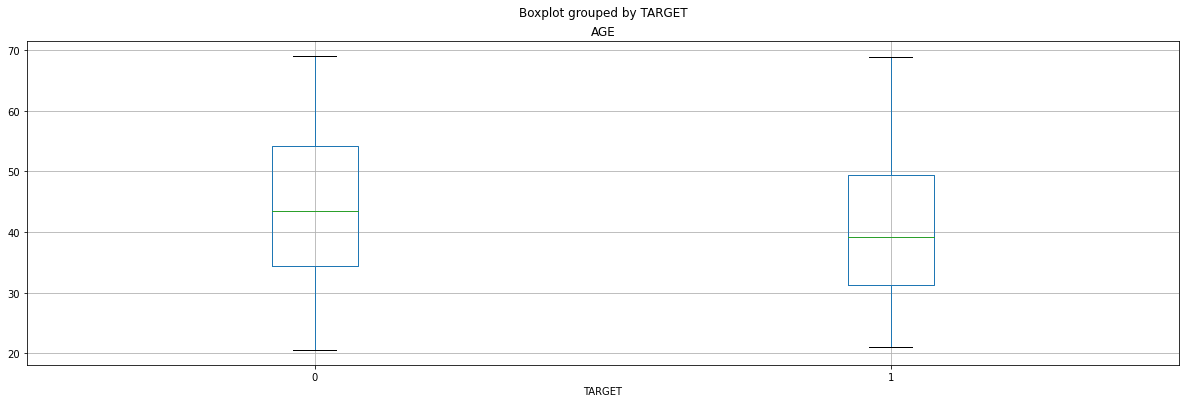

In [103]:
# DAYS_BIRTH
df_ca['AGE'] = (df_ca['DAYS_BIRTH']/365)*(-1)
df_ca.boxplot(column='AGE', by='TARGET', figsize = (20, 6))
df_ca[CA_CLIENT_COLUMNS + ['AGE']].describe()

In [ ]:
df_ca[['REGION_RATING_CLIENT']].info()
df_ca.astype({'REGION_RATING_CLIENT': 'category'})
df_ca[['REGION_RATING_CLIENT']].info()
df_ca[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].isna().sum()
df_ca['REGION_RATING_CLIENT'] = df_ca['REGION_RATING_CLIENT'].apply(lambda x: str(x))
df_ca['REGION_RATING_CLIENT_W_CITY'] = df_ca['REGION_RATING_CLIENT'].apply(lambda x: str(x))
print('REGION_RATING_CLIENT:', df_ca['REGION_RATING_CLIENT'].unique().tolist()) 
print('REGION_RATING_CLIENT_W_CITY:',df_ca['REGION_RATING_CLIENT_W_CITY'].unique().tolist())
df_ca[df_ca['REGION_RATING_CLIENT'] != df_ca['REGION_RATING_CLIENT_W_CITY']]
# TODO: Are labels matching the plot xticks? 
compare(df_ca, 'REGION_RATING_CLIENT', ['1', '2', '3'], 'Region')
# compare(df_ca, 'REGION_RATING_CLIENT_W_CITY', ['1', '2', '3'], 'Region W city')
print(df_ca.loc[df_ca['REGION_RATING_CLIENT'] != df_ca['REGION_RATING_CLIENT_W_CITY']][['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].shape[0])
print(df_ca.loc[df_ca['REGION_RATING_CLIENT'] > df_ca['REGION_RATING_CLIENT_W_CITY']][['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].shape[0])
print(df_ca.loc[df_ca['REGION_RATING_CLIENT'] < df_ca['REGION_RATING_CLIENT_W_CITY']][['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].shape[0])

- Both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY have same values. So only one can be considered
-  Clients from regions 3 have difficulty in paying off

### 2. Character - Credit Worthiness
- AMT_REQ_CREDIT_BUREAU_*
- 

In [ ]:
df_ca[(df_ca['SK_ID_CURR'].isin(curr_ids_multiple_prev_app))]['TARGET'].value_counts()
round(100. * df_ca['TARGET'].value_counts()/ len(df_ca['TARGET']),2)
df_ca[df_ca['TARGET'] == 1].to_csv("out/defaulter_curr_ids.csv")

In [98]:
for col in ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']:
    print(f"{col}: {percent(df_ca[col].isna().sum(),df_ca.shape[0])}%")
    print(df_ca[col].unique().tolist())
    #compare(df_ca, col, col,figsize=(20, 10))

AMT_REQ_CREDIT_BUREAU_HOUR: 14%
[0.0, nan, 1.0, 2.0, 3.0, 4.0]
AMT_REQ_CREDIT_BUREAU_DAY: 14%
[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, 8.0]
AMT_REQ_CREDIT_BUREAU_WEEK: 14%
[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, 7.0]
AMT_REQ_CREDIT_BUREAU_MON: 14%
[0.0, nan, 1.0, 2.0, 6.0, 5.0, 3.0, 7.0, 9.0, 4.0, 11.0, 8.0, 16.0, 12.0, 14.0, 10.0, 13.0, 17.0, 24.0, 19.0, 15.0, 23.0, 18.0, 27.0, 22.0]
AMT_REQ_CREDIT_BUREAU_QRT: 14%
[0.0, nan, 1.0, 2.0, 4.0, 3.0, 8.0, 5.0, 6.0, 7.0, 261.0, 19.0]
AMT_REQ_CREDIT_BUREAU_YEAR: 14%
[1.0, 0.0, nan, 2.0, 4.0, 5.0, 3.0, 8.0, 6.0, 9.0, 7.0, 10.0, 11.0, 13.0, 16.0, 12.0, 25.0, 23.0, 15.0, 14.0, 22.0, 17.0, 19.0, 18.0, 21.0, 20.0]


AMT_REQ_CREDIT_BUREAU_QRT: 14%
[0.0, nan, 1.0, 2.0, 4.0, 3.0, 8.0, 5.0, 6.0, 7.0, 261.0, 19.0]
24825
282686
                              Total  Target=1  Target=0  Target=1%  Target=0%
AMT_REQ_CREDIT_BUREAU_QRT                                                    
0.0                        215417.0   16905.0    198512        8.0       92.0
1.0                         33862.0    2227.0     31635        7.0       93.0
2.0                         14412.0    1203.0     13209        8.0       92.0
3.0                          1717.0     126.0      1591        7.0       93.0
4.0                           476.0      57.0       419       12.0       88.0
5.0                            64.0       6.0        58        9.0       91.0
6.0                            28.0       7.0        21       25.0       75.0
7.0                             7.0       1.0         6       14.0       86.0
8.0                             NaN       NaN         7        NaN        NaN
261.0                           Na

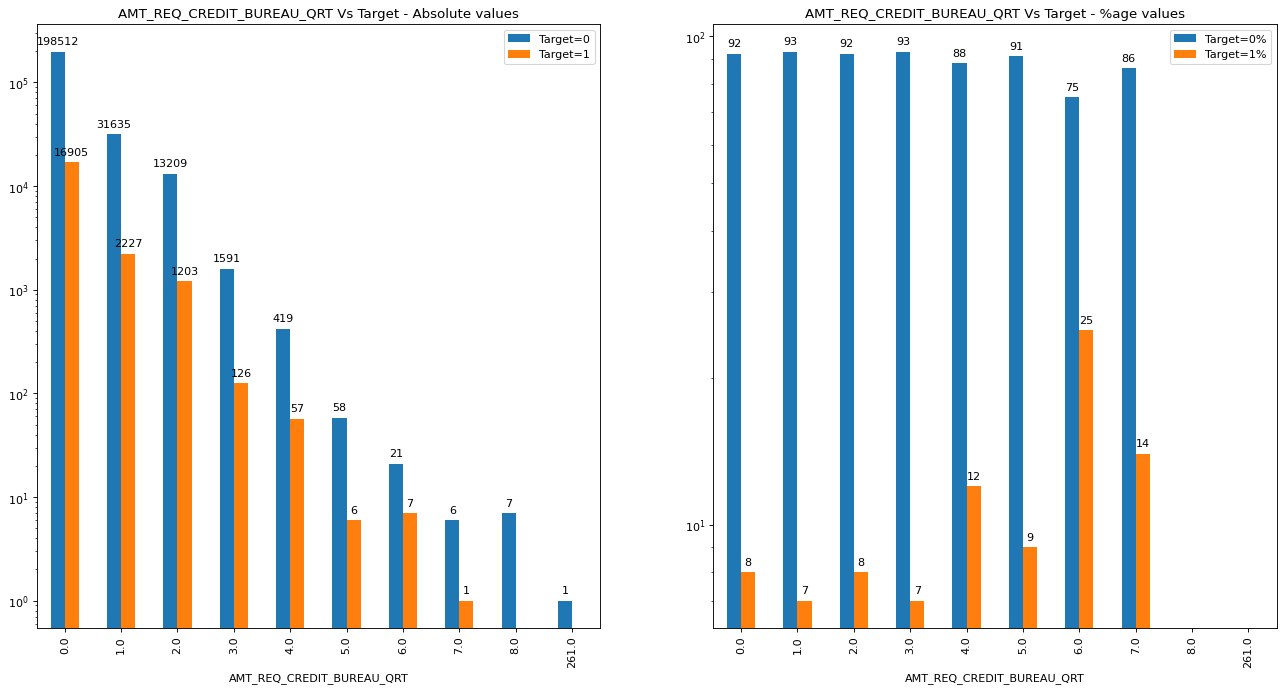

In [99]:
col = 'AMT_REQ_CREDIT_BUREAU_QRT'
print(f"{col}: {percent(df_ca[col].isna().sum(),df_ca.shape[0])}%")
print(df_ca[col].unique().tolist())
compare(df_ca, col, col,figsize=(20, 10))

24825
282686
                       Total  Target=1  Target=0  Target=1%  Target=0%
OCCUPATION_TYPE                                                       
Accountants             9813       474      9339        5.0       95.0
Cleaning staff          4653       447      4206       10.0       90.0
Cooking staff           5946       621      5325       10.0       90.0
Core staff             27570      1738     25832        6.0       94.0
Drivers                18603      2107     16496       11.0       89.0
HR staff                 563        36       527        6.0       94.0
High skill tech staff  11380       701     10679        6.0       94.0
IT staff                 526        34       492        6.0       94.0
Laborers               55186      5838     49348       11.0       89.0
Low-skill Laborers      2093       359      1734       17.0       83.0
Managers               21371      1328     20043        6.0       94.0
Medicine staff          8537       572      7965        7.0     

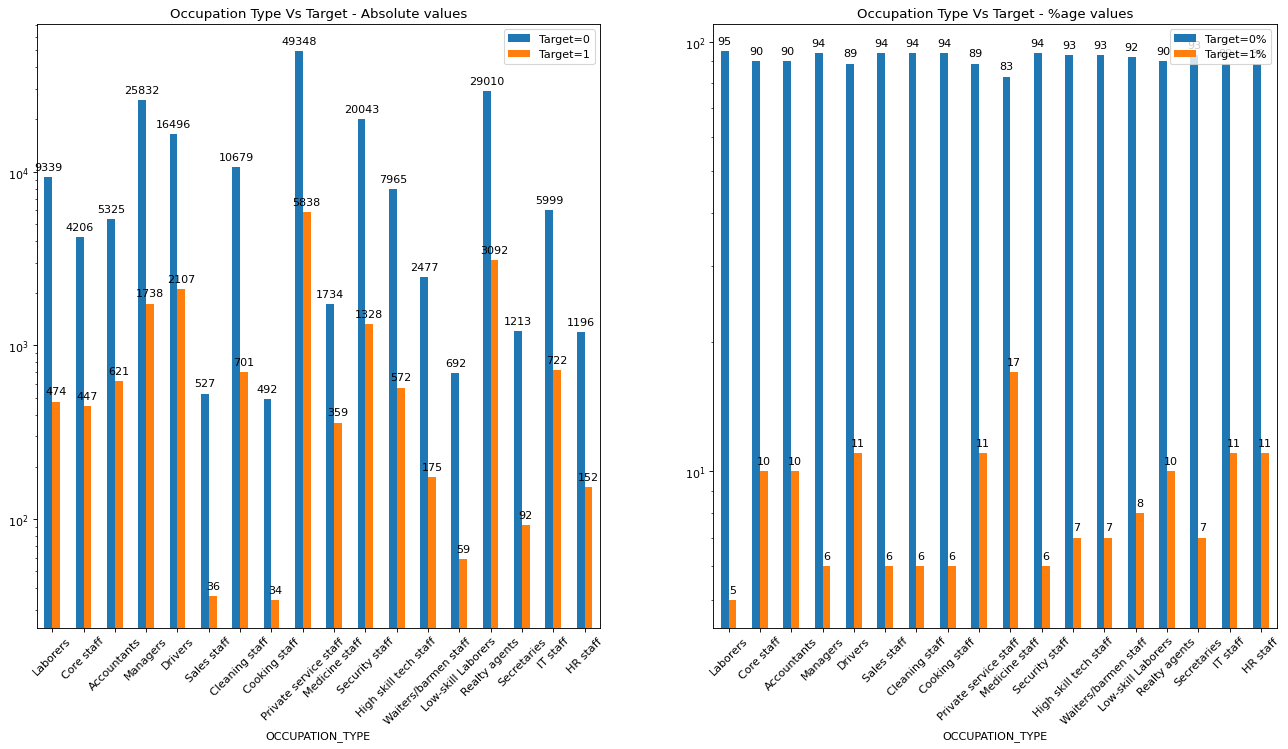

In [51]:
compare(df_ca, 'OCCUPATION_TYPE', 'Occupation Type', ['Laborers', 'Core staff', 'Accountants', 'Managers','Drivers','Sales staff','Cleaning staff',
 'Cooking staff', 'Private service staff', 'Medicine staff', 'Security staff','High skill tech staff','Waiters/barmen staff',
 'Low-skill Laborers', 'Realty agents','Secretaries', 'IT staff', 'HR staff'], figsize=(20, 10))

#### OBSERVATIONS:
- **Gender**: More percentage of male clients have difficulties in paying off
- **Education**: Clients with lower education have difficulties in paying off. Clients with academic degree are paying off. 
- **Occupation**: Clients who are private service staff find it difficult in paying off
- **Housing Type**: Clients in REnted apartment or staying at parents house have difficulties in paying off

TODO: Add income-credit info here

#### Credit history

In [ ]:
df_pa.groupby(by='SK_ID_CURR').agg({'SK_ID_PREV':'count'})

In [ ]:
df_pa_ca_status = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'],columns=['NAME_CONTRACT_STATUS'], aggfunc=['count'],fill_value=0) 
df_pa_ca_status.columns = df_pa_ca_status.columns.droplevel()
df_pa_ca_status.columns = df_pa_ca_status.columns.droplevel()
df_pa_ca_status

In [ ]:
df_pa_ca_counts = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'], aggfunc=['count'],fill_value=0) 
df_pa_ca_counts.columns = df_pa_ca_counts.columns.droplevel()
df_pa_ca_counts.rename(columns={'SK_ID_PREV':'Total Prev Apps'}, inplace=True)
df_pa_ca_counts

In [ ]:
df_pa_ca = df_pa_ca_counts.merge(df_pa_ca_status, how='inner', on='SK_ID_CURR')
df_pa_ca.reset_index(inplace=True)
df_pa_ca

In [ ]:
df_pa_ca['Refused%'] = round((df_pa_ca['Refused']/df_pa_ca['Total Prev Apps'])*100,2)
df_pa_ca[df_pa_ca['Refused%'] > 50].sort_values(by='Refused%', ascending= False)

In [ ]:
print(df_pa.shape[0], df_pa_ca['Total Prev Apps'].sum())

In [ ]:
curr_ids_rej_pa = df_pa_ca[df_pa_ca['Refused%'] > 75 ]['SK_ID_CURR']
print(curr_ids_rej_pa.shape[0])
curr_ids_rej_pa = curr_ids_rej_pa.tolist()
curr_ids_rej_pa[0:4]

In [ ]:
df_ca[df_ca['SK_ID_CURR'].isin(curr_ids_rej_pa)]#.groupby('TARGET').agg({'TARGET':'count'})

In [ ]:
pa_curr_ids = df_pa['SK_ID_CURR'].unique().tolist(); print(type(pa_curr_ids), len(pa_curr_ids), pa_curr_ids[0:4])
ca_curr_ids = df_ca['SK_ID_CURR'].unique().tolist(); print(type(ca_curr_ids), len(ca_curr_ids), ca_curr_ids[0:4])

curr_ids_with_prev_apps = list(set(pa_curr_ids) & set(ca_curr_ids))
print("Curr ids with prev apps:", type(curr_ids_with_prev_apps), len(curr_ids_with_prev_apps), curr_ids_with_prev_apps[0:4])

curr_ids_wo_prev_apps = set(ca_curr_ids).difference(set(pa_curr_ids))
print("Curr ids w/o prev apps:", type(curr_ids_wo_prev_apps), len(curr_ids_wo_prev_apps), list(curr_ids_wo_prev_apps)[0:4])

print("Verification: ", len(curr_ids_with_prev_apps) + len(curr_ids_wo_prev_apps), len(ca_curr_ids))

### 3. Capacity <a class="anchor" id="capacity"></a>
Borrower's ability to repay the loan
- Debt-to-income (DTI) ratio = total monthyl dept/gross monthly income
- DTI < 35% is safe
- Length of time an applicant is employed at their current job

Columns
- INCOME
- FLAG_OWN_CAR, FLAG_OWN_REALTY

* [Realty & Car](#realty-car)
* [Income](#income)

Borrower's ability to repay the loan
- Current debt
- Income
- Length of time employed at current job


COLUMNS
- FLAG_OWN_CAR      - categorical
- FLAG_OWN_REALTY   - categorical
- AMT_INCOME_TOTAL  - numerical, continuous, float

- FLAG_OWN_REALTY == 'Y' does not mean the client is staying there.
- NAME_HOUSING_TYPE indicates the type of housing where the client is staying. Not what he/she owns.

In [ ]:
df_ca[df_ca['FLAG_OWN_REALTY'] == 'Y'][['SK_ID_CURR','NAME_HOUSING_TYPE']].sort_values(by='NAME_HOUSING_TYPE', ascending=False)
df_ca[ (df_ca['FLAG_OWN_REALTY'] == 'N') & (~ df_ca['NAME_HOUSING_TYPE'].isna()) ][['SK_ID_CURR','FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE']]

In [ ]:
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']:
    df_= makeDFForTargets(df_ca, col)
    plotBar(df_, f"{col} Vs Target")
df_ca['AMT_INCOME_TOTAL']
df_ca.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6))
df_ca.quantile([0.9, 0.95, .9999])['AMT_INCOME_TOTAL']
CA_CLIENT_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='CLIENT')]['Row'].tolist()
CA_APPLICATION_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='APPLICATION')]['Row'].tolist()
CA_BUILDING_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='BUILDING')]['Row'].tolist()
df_ca_maxincome = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL'] + CA_CLIENT_COLUMNS ]
df_ca_maxincome[CA_CLIENT_COLUMNS]

#### Income, Credit, Goods

In [ ]:
df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL']]

In [ ]:

df_ca_red = df_ca[df_ca['SK_ID_CURR'] != 114967]
print(df_ca.shape[0], df_ca_red.shape[0])

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1, 3, 1)
ax = sns.scatterplot(df_ca_red['AMT_INCOME_TOTAL'], df_ca_red['AMT_CREDIT']); ax.set_xscale('log'); ax.set_title("Income Vs Credit")
plt.subplot(1, 3, 2)
ax = sns.scatterplot(df_ca_red['AMT_INCOME_TOTAL'], df_ca_red['AMT_GOODS_PRICE']); ax.set_xscale('log'); ax.set_title("Income Vs Goods Price")
plt.subplot(1, 3, 3)
ax = sns.scatterplot(df_ca_red['AMT_GOODS_PRICE'], df_ca_red['AMT_CREDIT']); ax.set_title("Goods Price Vs Credit")
plt.show()

# TODO: How to get the outliers? 

#### Realty Car <a name="realty-car"></a>

In [ ]:
print("Missing values: ")
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL']:
    print(f"{col:27}: {df_ca[col].isna().sum():7}")
df_ca[df_ca['FLAG_OWN_CAR'] == 'Y'][['SK_ID_CURR','OWN_CAR_AGE']].sort_values(by='OWN_CAR_AGE', ascending=False)
# TODO: OWN_CAR_AGE has NaN values where FLAG_OWN_CAR='Y'
# OWN_CAR_AGE - what is the unit? Is it in months or days?
#  Verify if car is not owned but has car age provided
df_ca[ (df_ca['FLAG_OWN_CAR'] == 'N') & (~df_ca['OWN_CAR_AGE'].isna()) ][['SK_ID_CURR','FLAG_OWN_CAR', 'OWN_CAR_AGE']]
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_= makeDFForTargets1(df_ca, col)
    print(df_.columns.to_list())
    plotBar(df_, f"{col} Vs Target")

# Whether a client owns a car/house or not does not seem to impact their ability to make payment

#### Income <a class="anchor" id="income"></a>

In [ ]:
df_ca.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6))

The boxplot shows that most of the incomes lie in a small range. While a few are extremely high. Is there a better visualization of this?

In [ ]:
#df_ca.plot.line(x='AMT_INCOME_TOTAL')

In [ ]:
df_ca.hist('AMT_INCOME_TOTAL', bins=228)

In [ ]:
# AMT_INCOME_TOTAL - numerical, continuous, float
# - No missing values
# - The spread is very skewed. So bin the income groups
# - Are there any particular income groups that struggle to pay back loans? or pay comfortably?
# - Income and other variables like credit amount
print(df_ca[['AMT_INCOME_TOTAL']].mean(), df_ca[['AMT_INCOME_TOTAL']].median())
print(df_ca[['AMT_INCOME_TOTAL']].quantile([0, 0.00005, 0.0005, 0.005, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99999, 1]))

In [ ]:
print(getIQR(df_ca,'AMT_INCOME_TOTAL'), getMaxScore(df_ca,'AMT_INCOME_TOTAL'))

In [ ]:
# Bin the AMT_INCOME_TOTAL into smaller groups
df_ca_copy = df_ca.copy()
df_ca_copy['INCOME_GROUP'] = pd.cut(df_ca_copy['AMT_INCOME_TOTAL'], [0, 50000, 100000, 1000000, 5000000, 200000000], labels=['<50K', '<1L', '<10L', '<50L', '>50L'])
income_groups = df_ca_copy['INCOME_GROUP'].value_counts(sort=False)
print(income_groups)
#plotBar(income_groups,"Income Groups", w=8, h=4, logy=True)

# Group the income bins based on TARGET
df_ca_copy_income = groupPerTarget(df_ca_copy, 'INCOME_GROUP')
plotBar(df_ca_copy_income[['Target=0%','Target=1%']], "Income Vs Target")

df_ca_copy_income

# TODO: 
# - Add % in the annotation
# - Plot according to quartile and check

##### **Observations**
- The spread of the income is very high. So binned the income groups

In [ ]:
df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']] # + CA_CLIENT_COLUMNS ]

In [ ]:
df_ca_max_income = df_ca[df_ca['SK_ID_CURR'] < 114967]
id, income, credit, goods_price = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']].to_list()
print(id, income, credit, goods_price, round(100 * credit/income,2))
print(100 * df_ca_max_income['AMT_CREDIT']/df_ca_max_income['AMT_INCOME_TOTAL'])

Max income value is 11 crores. Goods price is 4.5L and credit value is 5.6 L. The loan amount is < 1% of the income which seems bizzare. This can be removed.

In [ ]:
df_ca_red = df_ca[df_ca['AMT_INCOME_TOTAL'] < getMaxScore(df_ca,'AMT_INCOME_TOTAL')]
print(df_ca.shape[0], df_ca_red.shape[0])

In [ ]:
# Outliers - box plot
df_ca_red.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6))

### 4. Capital
- Down payment indicates borrower's level of seriousness
- Downpayment size
- Overall wealth that borrower possess - Car, Realty

#### Building

In [102]:
df_ca[CA_BUILDING_COLUMNS]
df_ca['BUILDING'] = 0
for col in ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI']:
    print(f"{col}: {percent(df_ca[col].isna().sum(), df_ca.shape[0])}%")
    df_ca['BUILDING'] = df_ca[col]
print(f"BUILDING {percent(df_ca['BUILDING'].isna().sum(), df_ca.shape[0])}%")

APARTMENTS_MEDI: 51%
BASEMENTAREA_MEDI: 59%
YEARS_BUILD_MEDI: 66%
COMMONAREA_MEDI: 70%
LANDAREA_MEDI: 59%
LIVINGAREA_MEDI: 50%
NONLIVINGAREA_MEDI: 55%
BUILDING 55%


- Since most information about the building is not present we could ignore this variable in our analysis

#### Application

In [ ]:
df_ca['OWN_CAR_AGE'].describe()
for col in ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    df_ca.boxplot(column=col, by='TARGET', figsize = (20, 6))

In [ ]:
df_ca[['SK_ID_CURR'] + CA_APPLICATION_COLUMNS]

In [ ]:
CA_FLAG_DOCUMENT_COLUMNS = list(filter(lambda x: x[:14] == 'FLAG_DOCUMENT_', df_ca.columns.tolist()))
CA_FLAG_DOCUMENT_COLUMNS

In [ ]:
import functools
#df_ca['FLAG_DOCUMENT'] = df_ca[CA_FLAG_DOCUMENT_COLUMNS].apply(lambda row: functools.reduce(lambda a, b: a+b, row))
df_ca['FLAG_DOCUMENT'] = functools.reduce(lambda a, b: a+b, [df_ca[col] for col in CA_FLAG_DOCUMENT_COLUMNS])
df_ca[['SK_ID_CURR', 'FLAG_DOCUMENT'] + CA_FLAG_DOCUMENT_COLUMNS]

In [ ]:
df_ca['FLAG_DOCUMENT'].describe()

In [ ]:
#  df_ca.plot.bar('FLAG_DOCUMENT', figsize = (20, 6))
df_ca['FLAG_DOCUMENT'].value_counts()

In [ ]:
df_ca[df_ca['FLAG_DOCUMENT']==4]

## Data Standardisation
- Remove decimals from the amounts
- Convert age to years & months - not days
- Convert amounts to K or L? 
- Convert numeric flags to categorical values

## Data Cleaning - Handle missing data

In [ ]:
## Missing Values
listColumsWithMissingData(df_ca)

In [ ]:
listColumsWithMissingData(df_pa)

## Outliers

## Correlation 

In [ ]:
df_ca.columns.tolist()[:50]

In [ ]:
sns.heatmap(df_ca[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','TARGET']].corr());plt.show()

In [ ]:
sns.pairplot(data=df_ca_red[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','TARGET']])

In [ ]:
plotBar(df_ca_red['CNT_CHILDREN'])